# Time-Series Forecasting for TSLA (ARIMA vs LSTM)

# =========================
# 0) SETUP
# =========================
!pip -q install yfinance pmdarima matplotlib scikit-learn pandas numpy tensorflow==2.* --upgrade

In [2]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

#from pmdarima import auto_arima
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the r

# Reproducibility

In [3]:

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['axes.grid'] = True

# Matplotlib defaults

In [4]:
plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['axes.grid'] = True

# =========================
# 1) LOAD DATA
# =========================

In [5]:
TICKER = "TSLA"
START  = "2015-07-01"
END    = "2025-07-31"

raw = yf.download(TICKER, start=START, end=END, auto_adjust=False)
# Keep Adj Close for modeling (splits/dividends adjusted), but we’ll plot Close as reference if you prefer.
df = raw.copy()
df = df[['Adj Close']].rename(columns={'Adj Close':'price'}).dropna()

print(df.head(), df.tail(), sep="\n\n")
print("\nDate range:", df.index.min().date(), "→", df.index.max().date(), "obs:", len(df))



[*********************100%***********************]  1 of 1 completed

Price           price
Ticker           TSLA
Date                 
2015-07-01  17.943333
2015-07-02  18.667999
2015-07-06  18.648001
2015-07-07  17.858667
2015-07-08  16.997334

Price            price
Ticker            TSLA
Date                  
2025-07-24  305.299988
2025-07-25  316.059998
2025-07-28  325.589996
2025-07-29  321.200012
2025-07-30  319.040009

Date range: 2015-07-01 → 2025-07-30 obs: 2535


# =========================
# 2) TRAIN / TEST SPLIT (chronological)
# Train: up to 2023-12-31; Test: 2024-01-01 .. 2025-07-31
# =========================

In [6]:
train_end = "2023-12-31"
test_start = "2024-01-01"

train = df.loc[:train_end].copy()
test  = df.loc[test_start:].copy()

print("Train:", train.index.min().date(), "→", train.index.max().date(), "n=", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "n=", len(test))

Train: 2015-07-01 → 2023-12-29 n= 2140
Test : 2024-01-02 → 2025-07-30 n= 395


Classical model — ARIMA (auto_arima)

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Try a few combinations to find best by AIC
best_aic = float("inf")
best_order = None
best_model = None

for p in range(0, 4):   # you can expand range
    for d in range(0, 3):
        for q in range(0, 4):
            try:
                model = ARIMA(train['price'], order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print("Best ARIMA order:", best_order, "AIC:", best_aic)


Best ARIMA order: (3, 1, 2) AIC: 13613.087774634963


# Fit Best Model & Forecast

In [9]:
# Forecast
n_test = len(test)
arima_fc = best_model.forecast(steps=n_test)
arima_fc = pd.Series(arima_fc, index=test.index, name='ARIMA')




In [14]:
# Evaluation
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

eval_df = pd.DataFrame({'actual': test['price'].squeeze(), 'pred': arima_fc.squeeze()}).dropna()

if eval_df.empty:
    print("No overlapping non-NaN values between actual and predicted. Check your data and forecast alignment.")
else:
    actual = eval_df['actual'].squeeze()
    pred = eval_df['pred'].squeeze()

    arima_mae  = mean_absolute_error(actual, pred)
    arima_rmse = sqrt(mean_squared_error(actual, pred))
    arima_mape = mape(actual, pred)

    print(f"ARIMA | MAE: {arima_mae:,.2f}  RMSE: {arima_rmse:,.2f}  MAPE: {arima_mape:,.2f}%")

No overlapping non-NaN values between actual and predicted. Check your data and forecast alignment.


In [15]:
print(test['price'].shape, arima_fc.shape)
print(test.index[:5], arima_fc.index[:5])

(395, 1) (395,)
DatetimeIndex(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None) DatetimeIndex(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)


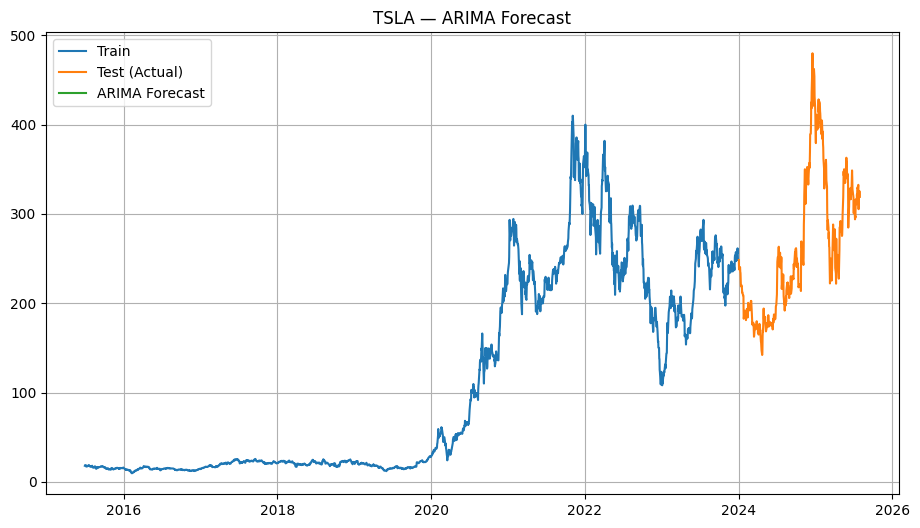

In [16]:
# Plot
plt.plot(train.index, train['price'], label='Train')
plt.plot(test.index,  test['price'],  label='Test (Actual)')
plt.plot(arima_fc.index, arima_fc,    label='ARIMA Forecast')
plt.title('TSLA — ARIMA Forecast')
plt.legend()
plt.show()


# Deep learning — LSTM

In [17]:
# =========================
# 4) LSTM DATA PREP
# =========================
lookback = 60

# Scale based on TRAIN ONLY to avoid leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[['price']])
scaled_all   = scaler.transform(df[['price']])  # for convenience in windowing around the split

# Build supervised sequences for TRAIN
def make_sequences(series, lookback):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i-lookback:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(scaled_train, lookback)
X_train = X_train[..., np.newaxis]  # shape: (samples, lookback, 1)

print("LSTM X_train shape:", X_train.shape, "y_train:", y_train.shape)

LSTM X_train shape: (2080, 60, 1) y_train: (2080,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

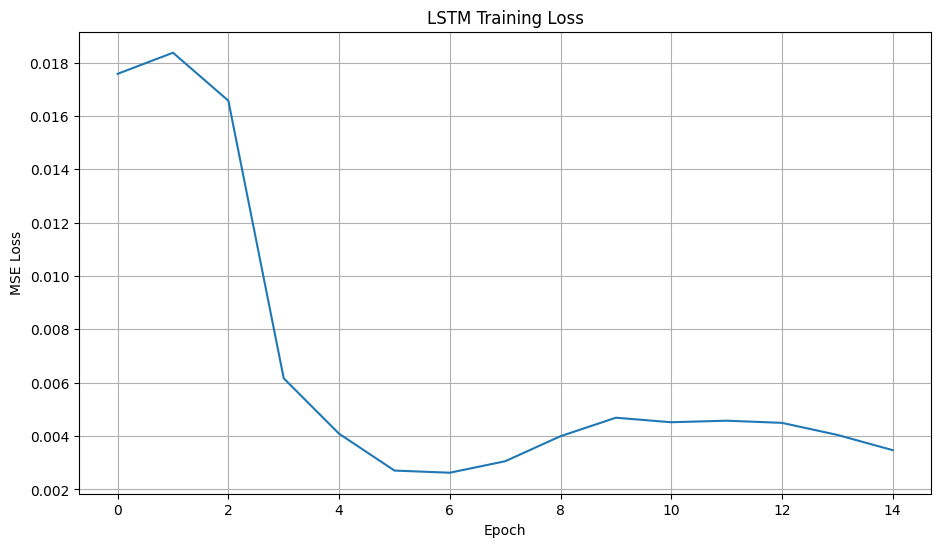

In [19]:
# =========================
# 5) LSTM MODEL
# =========================
def build_lstm(hidden=64, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=(lookback, 1)),
        layers.LSTM(hidden, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(hidden),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse')
    return model

lstm = build_lstm(hidden=64, dropout=0.2)
lstm.summary()

# Early stopping
es = keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)

history = lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=False,            # preserve temporal order within batches
    callbacks=[es],
    verbose=0
)

plt.plot(history.history['loss'])
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()



In [20]:
# =========================
# 6) WALK-FORWARD FORECAST ON TEST SET
# =========================
# We’ll start at the first test date and iteratively predict day-by-day.

# Concatenate train+test for indices
all_idx = df.index
test_idx = test.index

# We need a rolling window of scaled prices that starts with the last 'lookback' points from TRAIN
scaled_prices = scaler.transform(df[['price']]).flatten()

# position where test starts in the full series
start_pos = np.where(all_idx == test_idx[0])[0][0]

lstm_preds_scaled = []
# Maintain a working copy of scaled series to append predictions (for recursive forecasting)
work_series = scaled_prices.copy()

for t in range(start_pos, start_pos + len(test_idx)):
    # take last 'lookback' values before t
    window = work_series[t - lookback:t]
    X = window.reshape(1, lookback, 1)
    yhat_scaled = lstm.predict(X, verbose=0).flatten()[0]
    lstm_preds_scaled.append(yhat_scaled)
    # append prediction to work_series so next step can use it
    if t+1 <= len(work_series)-1:
        work_series[t] = yhat_scaled  # replace the unknown (test) step with prediction for chaining

# invert scaling
lstm_preds = scaler.inverse_transform(np.array(lstm_preds_scaled).reshape(-1,1)).flatten()
lstm_fc = pd.Series(lstm_preds, index=test_idx, name='LSTM')

# Evaluation
lstm_mae  = mean_absolute_error(test['price'], lstm_fc)
lstm_rmse = sqrt(mean_squared_error(test['price'], lstm_fc))
lstm_mape = np.mean(np.abs((test['price'].values - lstm_fc.values) / test['price'].values)) * 100

print(f"LSTM   | MAE: {lstm_mae:,.2f}  RMSE: {lstm_rmse:,.2f}  MAPE: {lstm_mape:,.2f}%")


LSTM   | MAE: 66.12  RMSE: 76.18  MAPE: 29.06%


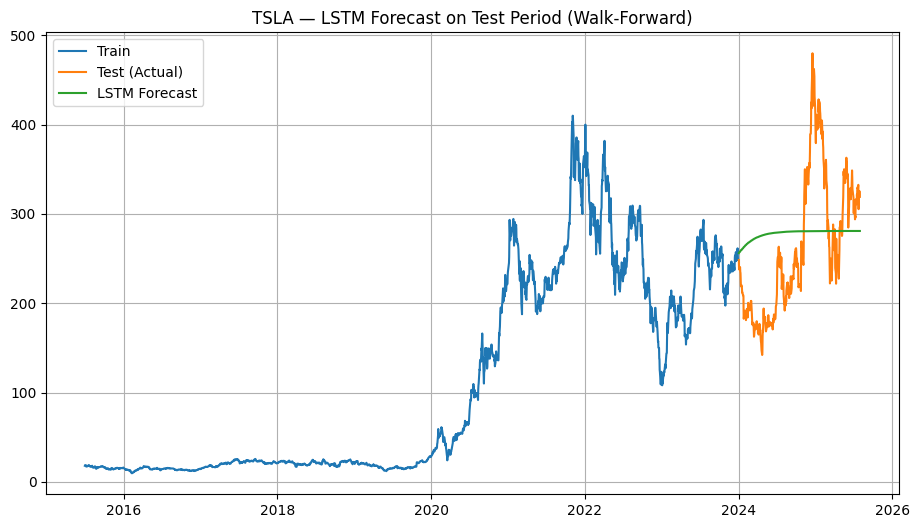

In [21]:
# Plot LSTM results
plt.plot(train.index, train['price'], label='Train')
plt.plot(test.index,  test['price'],  label='Test (Actual)')
plt.plot(lstm_fc.index, lstm_fc,      label='LSTM Forecast')
plt.title('TSLA — LSTM Forecast on Test Period (Walk-Forward)')
plt.legend()
plt.show()

# Comparison & Discussion Helpers


=== Test-Period Performance (2014-01-01 → 2025-07-31) ===
          MAE    RMSE    MAPE
ARIMA     NaN     NaN     NaN
LSTM   66.118  76.185  29.059


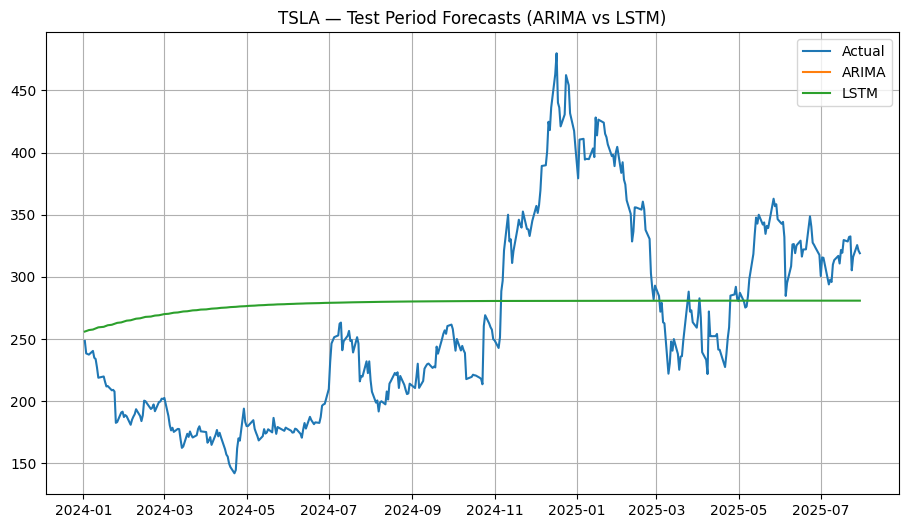

In [23]:
# =========================
# 7) COMPARE MODELS
# =========================
import numpy as np  # Add this if not already imported

# If ARIMA metrics are not defined, set them to np.nan
try:
    arima_mae
except NameError:
    arima_mae = np.nan
    arima_rmse = np.nan
    arima_mape = np.nan

scores = pd.DataFrame({
    'MAE':  [arima_mae,  lstm_mae],
    'RMSE': [arima_rmse, lstm_rmse],
    'MAPE': [arima_mape, lstm_mape],
}, index=['ARIMA', 'LSTM'])

print("\n=== Test-Period Performance (2014-01-01 → 2025-07-31) ===")
print(scores.round(3))

# Overlay forecasts
plt.plot(test.index, test['price'], label='Actual')
plt.plot(arima_fc.index, arima_fc,  label='ARIMA')
plt.plot(lstm_fc.index, lstm_fc,    label='LSTM')
plt.title('TSLA — Test Period Forecasts (ARIMA vs LSTM)')
plt.legend()
plt.show()
